Amazon Alexa Review -sentiment Analsis
Analyzing the amazon alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative

Importing required Libraries 

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords 
STOPWORDS = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\I-SEVEN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Exploratory Data Analsis

In [2]:
#Load the data
data =pd.read_csv(r"amazon_alexa.tsv" ,delimiter="\t" )
print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [3]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
#column names 
print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [5]:
#Check for null values 
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

there is  one record with 'Verified_reviews' null value

In [6]:
#Getting the record where 'Verified_reviews' is null
data[data['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [7]:
#we will drop the null record 
data.dropna(inplace=True)

In [8]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (3149, 5)


In [9]:
#creating a new column 'length' of the string in "Verfied_reviews" column
data['length'] =data['verified_reviews'].apply(len)

In [10]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [11]:
#Randomly checking for 10th record
print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #Original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: I sent it to my 85 year old Dad, and he talks to it constantly.
Length of review : 63
'length' column value : 63


In [12]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [13]:
len(data)

3149

In [14]:
print(f"Rating value count :\n {data['rating'].value_counts()}")

Rating value count :
 rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


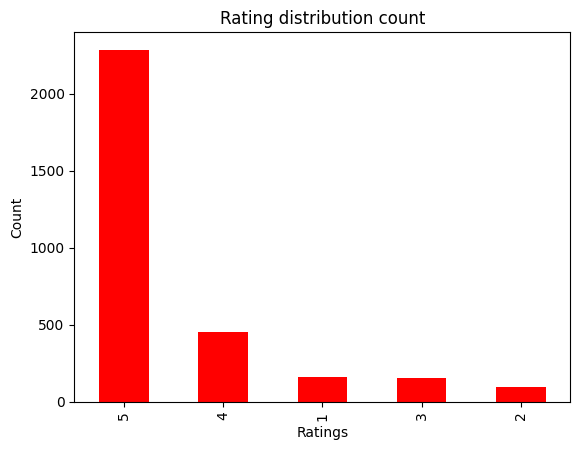

In [15]:
#Bar plot to visualize the total counts of each rating
data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [16]:
print(f"Rating value count - percentage distribution :\n {round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution :
 rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


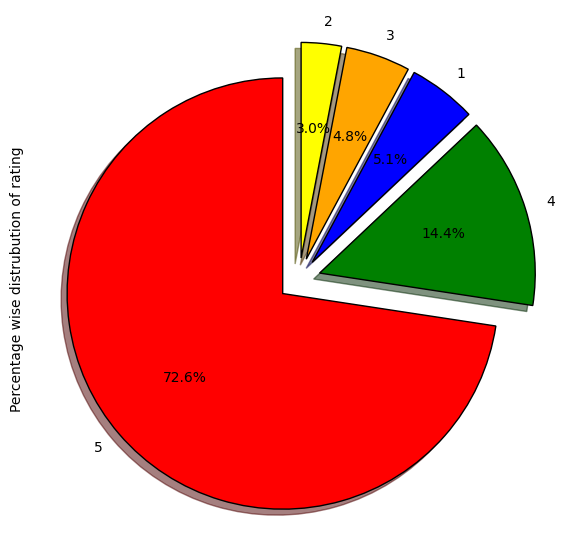

In [17]:

fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

In [18]:
print(f"Feedback value count :\n {data['feedback'].value_counts()}")

Feedback value count :
 feedback
1    2893
0     256
Name: count, dtype: int64


In [19]:
review_0=data[data['feedback']==0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [20]:
review_1=data[data['feedback']==1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


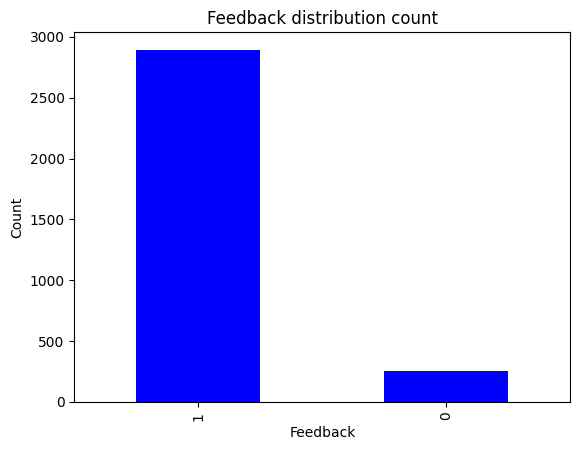

In [21]:
#Bar graph to visualize the total counts of each feedback
data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [22]:
print(f"Feedback value count - percentage distribution :\n {round(data['feedback'].value_counts()/data.shape[0]*100,2)} ")

Feedback value count - percentage distribution :
 feedback
1    91.87
0     8.13
Name: count, dtype: float64 


<Axes: ylabel='Percentage wise distrubution of feedback'>

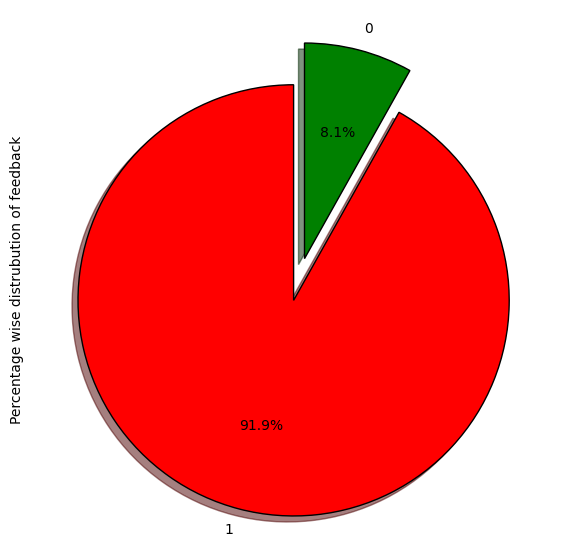

In [23]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

In [24]:
data[data["feedback"]==0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [25]:
data[data["feedback"]==1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [26]:
print(f"Variation value count :\n {data['variation'].value_counts()}")

Variation value count :
 variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


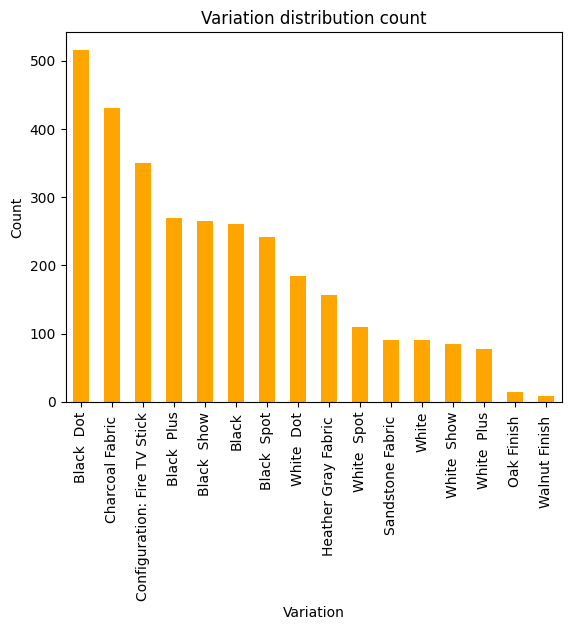

In [27]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [28]:
print(f"variation value count _percentage  distribution :\n {round(data['variation'].value_counts()/data.shape[0]*100,2)}")

variation value count _percentage  distribution :
 variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [29]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

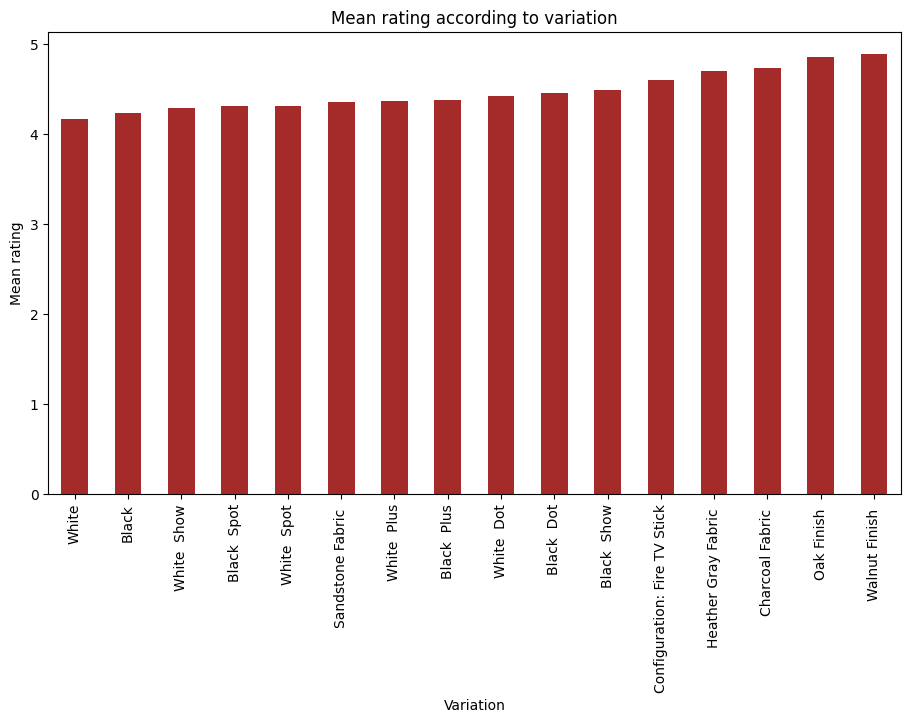

In [30]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

In [31]:
data['length'].describe()

count    3149.000000
mean      132.090187
std       182.114569
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review ')]

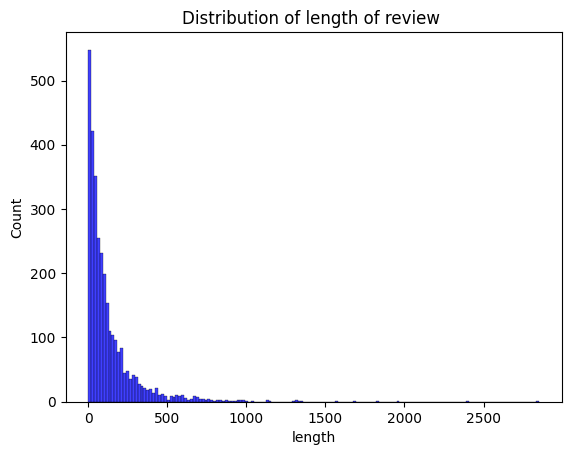

In [32]:

sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

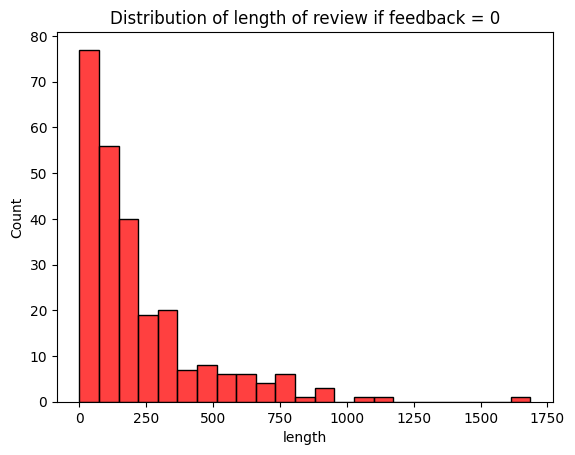

In [33]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

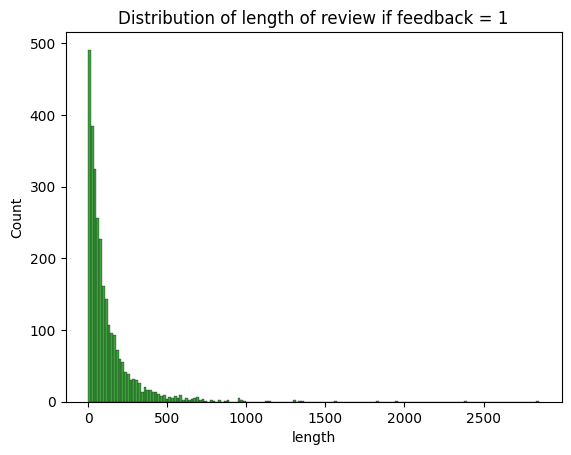

In [34]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

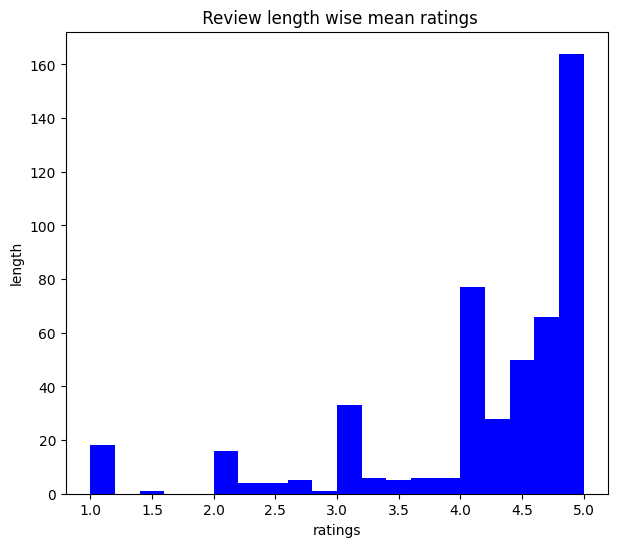

In [35]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [36]:
cv =CountVectorizer(stop_words='english')
words= cv.fit_transform(data.verified_reviews)

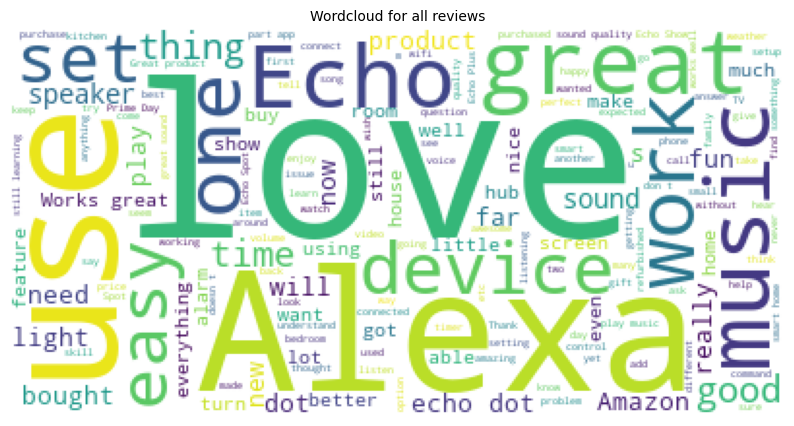

In [37]:
#combine all reviews
reviews=" ".join([review for review in data ['verified_reviews']])
#initialize wordcloud object 
wc= WordCloud(background_color='white')
# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()


In [38]:

# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

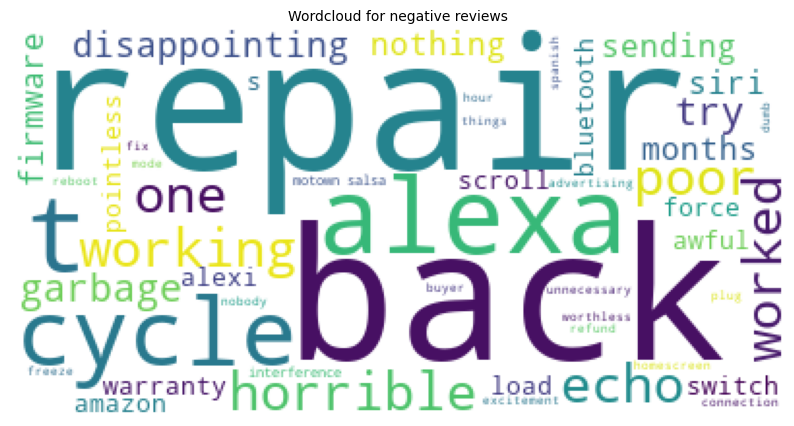

In [39]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

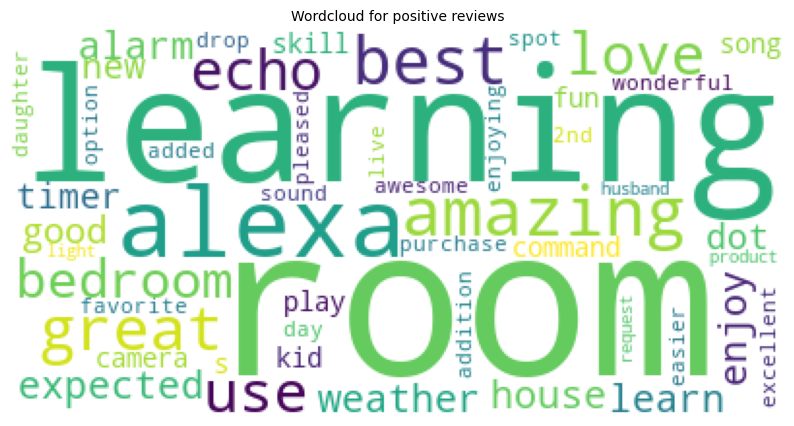

In [40]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

=========================================================

#Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following -

1-Replace any non alphabet characters with a space
2-Covert to lower case and split into words
3-Iterate over the individual words and if it is not a   stopword then add the stemmed form of the word to the corpus

In [41]:
# Load stopwords correctly
stop_words = set(stopwords.words('english'))  # Convert to a set for fast lookup

corpus = []
stemmer = PorterStemmer()

for i in range(0, data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])  # Remove non-alphabet characters
    review = review.lower().split()  # Convert to lowercase and split into words
    review = [stemmer.stem(word) for word in review if word not in stop_words]  # Stem words and remove stopwords
    review = ' '.join(review)  # Join words back into a string (added space for readability)
    corpus.append(review)


In [42]:
cv = CountVectorizer(max_features=2500)
#Sorting independent and dependent variables in x and y
x= cv.fit_transform(corpus).toarray()
y =data['feedback'].values 

In [43]:
#Saving the Count Vectorizer
# Create 'Models' directory if it doesn't exist
os.makedirs('Models', exist_ok=True)

# Save the CountVectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))


In [44]:

print(f"X shape: {x.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [46]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


In [47]:
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [48]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

MODEL 1 RANDOM FOREST

In [49]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [50]:

#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9941016333938294
Testing Accuracy : 0.9428571428571428


In [51]:

#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [52]:

#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

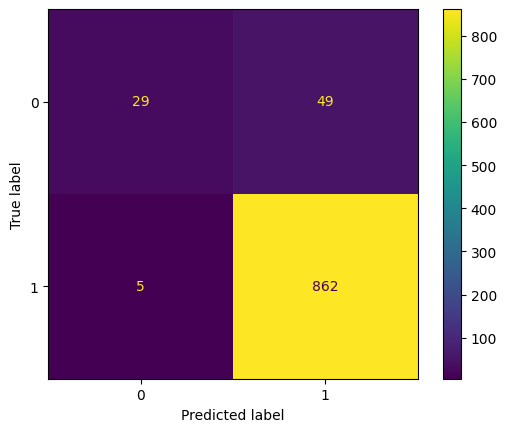

In [53]:

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [54]:

accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9319477581242287
Standard Variance : 0.010708919331885171


In [55]:

params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [56]:

cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [57]:

#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 100}


In [58]:

print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 96.80694192377494
Cross validation mean accuracy on test set : 92.17332123411978
Accuracy score for test set : 0.9428571428571428


MODEL 2XGBOOST MODEL

In [59]:

model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [60]:

#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.971415607985481
Testing Accuracy : 0.9417989417989417


In [61]:

y_preds = model_xgb.predict(X_test)

In [62]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 31  47]
 [ 13 854]]


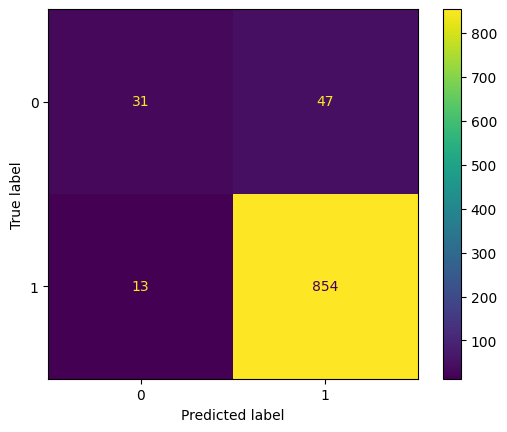

In [63]:

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [64]:

#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

MODEL 3 DECISION TREE CLASSIFIER

In [65]:

model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [66]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9941016333938294
Testing Accuracy : 0.9185185185185185


In [67]:
y_preds = model_dt.predict(X_test)

In [68]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 42  36]
 [ 91 776]]


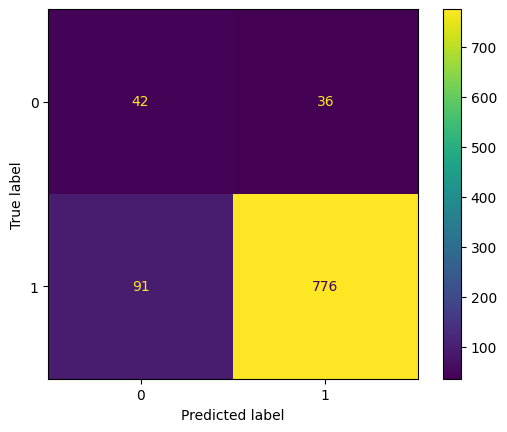

In [69]:

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()